# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from PIL import Image, ImageDraw

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from torchvision.models._utils import IntermediateLayerGetter 

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", device)

device: cuda


# ConvNets



## Training

For our first problem, we are going to design a simple ConvNet to predict the labels on the MNIST dataset. Rather than using an MLP like your previous assignments, we are going to use ConvNets to improve the performance with a reduced parameter count.

First, let us load in the dataset from the TorchVision library.

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_set = datasets.MNIST('./', download=True, train=True, transform=transform)
test_set = datasets.MNIST('./', download=True, train=False, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 204140739.29it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23407863.54it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 55822837.97it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15968590.75it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Next, we need to create `DataLoader`s for the subsets.

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)  # Your code goes here.
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)  # Your code goes here.

Let's also define an simple `transform` to normalize our inputs:

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

Finally, we need to define the architecture of our model. We can use the `nn.Sequential` API considering the simple architecture that this dataset would require. Note that the images are $28 \times 28$ pixels.

In [9]:
input_size = 28 * 28
classes_count = 10

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2)  # output shape (28 * 28 * 64)
        self.dropout = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2) # output shape (14 * 14 * 128)
        self.fc = nn.Linear(7*7*128, classes_count)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc(x)
        x = F.log_softmax(x)
        
        return x


net = CNN()
net.to(device)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout(p=0.1, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)

We also need to set up a loss function (often referred to as the criterion) and an optimizer. You can use the suggested values shown below:

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())

We now need to implement a simple loop for training the model. For this step, rather than implementing the entire pipeline yourself, you can use [Ignite](https://pytorch-ignite.ai/), which comes predefined training and evaluation loops, metrics, etc.

In [17]:
from tqdm import tqdm

def accuracy(y_pred, y):
    """
    Calculating the accuracy of given batch.
    input(s):
    y_pred (ndarray): predicted logits or the output of the model.
    y (ndarray): labels
    """
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

def train(trainloader, model, optimizer, criterion, n_epochs):
    history = dict()
    history['train_loss']= list()
    history['train_acc']= list()

    for epoch in range(n_epochs):
        running_loss = 0
        running_acc = 0

        model.train()
        for idx, (X, y) in enumerate(tqdm(trainloader)):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy(y_hat, y)
        else:
            running_loss = running_loss/ len(trainloader)
            running_acc = running_acc / len(trainloader)
            history['train_loss'].append(running_loss)
            history['train_acc'].append(running_acc)
            print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')

    return history

With only two convolutional layers, you should be able to reach above 97% accuracy on the test set.

In [18]:
train(train_loader, net, optimizer, criterion, 10)

  0%|          | 0/938 [00:00<?, ?it/s]<ipython-input-15-d4995c788583>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
100%|██████████| 938/938 [00:27<00:00, 34.68it/s]


Epoch 1/10 : training loss: 0.11105363050188774, training acc: 0.9659681503198294


100%|██████████| 938/938 [00:20<00:00, 45.39it/s]


Epoch 2/10 : training loss: 0.040944081685157806, training acc: 0.9871901652452025


100%|██████████| 938/938 [00:21<00:00, 44.11it/s]


Epoch 3/10 : training loss: 0.029692124512995646, training acc: 0.990238539445629


100%|██████████| 938/938 [00:20<00:00, 45.04it/s]


Epoch 4/10 : training loss: 0.022234017432603614, training acc: 0.9931369936034116


100%|██████████| 938/938 [00:20<00:00, 44.80it/s]


Epoch 5/10 : training loss: 0.017411392109604264, training acc: 0.994103144989339


100%|██████████| 938/938 [00:21<00:00, 42.95it/s]


Epoch 6/10 : training loss: 0.01619337226517311, training acc: 0.9945029317697228


100%|██████████| 938/938 [00:21<00:00, 44.49it/s]


Epoch 7/10 : training loss: 0.014255861780601486, training acc: 0.9953524786780383


100%|██████████| 938/938 [00:20<00:00, 45.67it/s]


Epoch 8/10 : training loss: 0.011678307069773434, training acc: 0.996202025586354


100%|██████████| 938/938 [00:21<00:00, 44.37it/s]


Epoch 9/10 : training loss: 0.011096782769114097, training acc: 0.9961853678038379


100%|██████████| 938/938 [00:21<00:00, 44.04it/s]

Epoch 10/10 : training loss: 0.010762689704556854, training acc: 0.9964019189765458


{'train_loss': [0.11105363050188774,
  0.040944081685157806,
  0.029692124512995646,
  0.022234017432603614,
  0.017411392109604264,
  0.01619337226517311,
  0.014255861780601486,
  0.011678307069773434,
  0.011096782769114097,
  0.010762689704556854],
 'train_acc': [0.9659681503198294,
  0.9871901652452025,
  0.990238539445629,
  0.9931369936034116,
  0.994103144989339,
  0.9945029317697228,
  0.9953524786780383,
  0.996202025586354,
  0.9961853678038379,
  0.9964019189765458]}

In [19]:
def test(testloader, model):
    # Test the model
    model.eval()

    test_acc = 0
    with torch.no_grad():

        for idx, (X, y) in enumerate(tqdm(testloader)):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            test_acc = accuracy(y_hat, y)
    
    print('Test Accuracy of the model', test_acc)

In [20]:
test(test_loader, net)

  0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-15-d4995c788583>:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
100%|██████████| 157/157 [00:02<00:00, 60.56it/s]

Test Accuracy of the model 1.0


## Interpretation

In this assignment, rather than merely training a ConvNet, we want to see what is actually going on inside a ConvNet. This task, which is generally referred to as interpretation of a model, can be accomplished via few different methods in ConvNets. 

Let's begin by loading in a pretrained **ResNet** model. *TorchVision* comes with a library of models that have been trained on the massive [ImageNet](https://www.image-net.org/) dataset, which contains a thousand different classes. You can learn more about them [here](https://pytorch.org/vision/stable/models.html). 

For this assignment, we will be using **ResNet-50**, specifically its `IMAGENET1K_V2` variant. You should also instantiate the corresponding class names.

In [50]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.IMAGENET1K_V2
resnet = resnet50(weights=weights)  # Your code goes here.
class_names = weights.meta["categories"]  # Your code goes here.

We also need to construct an appropiate transform. You can get these values from the documentations.

In [51]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

We can peak into the architecture of the loaded model quite easily. We can expect to see the same layers that were listed on the course slides (DL-13:24).

In [52]:
resnet 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

We also need to load in an input image that we can use to analyze the behavior of our model. We have included an image of a cat and a dog along with the assignment materials. Feel free to use any other image that you'd like, but note that for the purposes of this assignment, it should contain at least two objects of different classes that are present in the ImageNet dataset.

In [53]:
im = Image.open('a-cat-and-a-dog.png')

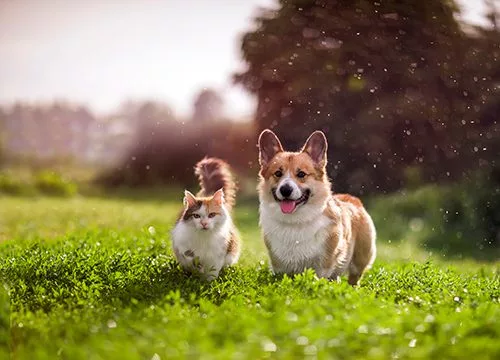

In [54]:
im

If we pass this image to our pretrained ResNet:

In [55]:
sample = preprocess(im)
batch = sample.unsqueeze(0)
logits = resnet(batch)
logits = logits.squeeze()

We will get a 1000-D vector known as *logits*. These are the outputs of the `Linear` layer before they have been preprocessed by `Softmax` and therefore, are not probability values in the $[0, 1]$ range. Yet, since softmax is a monotonic function, we can simply find the maximum classes in this vector in order to find the categories with the highest likelihoods. Let's take a look at the top five:

In [56]:
values, indices = torch.topk(logits, 3)
indices

tensor([264, 263, 227])

We can translate the class IDs using the dictionary we loaded from `IMAGENET1K_V2` and display them along with their logits and probablities:

In [57]:
proba = torch.softmax(logits, 0)
for index in indices:
    print(class_names[index], f'Likelihood: {proba[index].item()*100:.2f}%', f'({logits[index].item():.4f})')

Cardigan Likelihood: 0.27% (0.9956)
Pembroke Likelihood: 0.26% (0.9551)
kelpie Likelihood: 0.18% (0.6140)


It seems that ResNet has been able to correctly identify the corgi dog in the image (pembroke). The most likely class (cardigan) is another dog breed and still a good guess. However, the third class is completely off! Interpretation can help us understand why ResNet has made such a prediction.

### Kernel Visualization

You have already seen an example of this method in the course slides. We can visualize the learned kernels in a ConvNet to see what they are *reacting* to. 

![Kernels](https://discuss.pytorch.org/uploads/default/original/2X/0/09a4f74777539ac7fbf0715e6cdb9415a30eb730.jpeg)

It is quite simple to visualize the kernels. In PyTorch, you can access the learned weights of a `Conv2D` layer by accessing its `weight` attributes. You should [`detach()`](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) and [`clone()`](https://pytorch.org/docs/stable/generated/torch.clone.html) the tensor. Check out the linked documentation pages to learn why. 

We will only focus on the `conv1` layer in ResNet-50. 

In [58]:
kernels = torch.clone(resnet.conv1.weight).detach() # Your code goes here.

In [59]:
kernels.shape

torch.Size([64, 3, 7, 7])

We should upscale the maps for better visualization:

In [60]:
kernels = F.interpolate(kernels, size=64)

We can visualize the 7x7 kernels using `matplotlib`.

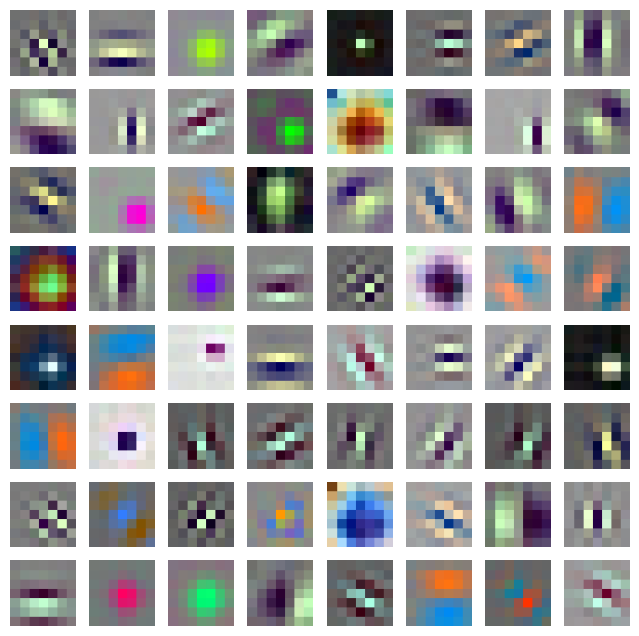

In [61]:
figure, axes = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        index = i * 8 + j
        kernel = kernels[index]
        kernel = kernel - kernel.min()
        kernel = kernel / kernel.max()
        kernel = kernel.permute(1, 2, 0).numpy()
        axes[i, j].imshow(kernel)
        axes[i, j].axis('off')
plt.show()

Visualizing the other convolutional layers that are deeper into the model is a bit more difficult. You would need to recursively walk through the network and merge the kernels to end up something with an RGB input. However, we won't need to go through with that. We got a few more techniques that can help us interpret the inner workings of our ConvNet.

### Feature Maps

Feature maps, also known as activation maps, are the outputs of the convolutional layers. Higher values indicate a stronger matching between the input image and what the kernel has learned to look for. 

As discussed in the class, the convolutional layers in a ConvNet gradually build up on top of another, progressively raising the *abstraction* level; while the earlier layers are occupied with edges and corners and basic color patterns, the later layers react to concepts that are much closer to our target classes. For example, in the case of our sample image, the earlier layers might be reacting to the fur or the shape of the ears of the animals, while the final layers put these pieces of information together to arrive at the conclusion that *there's a cat in this image*!

Let's take a look at the outputs of 4 building blocks of ResNet. We can get their corresponding outputs using `IntermediateLayerGetter`. This is an undocumented module in *TorchVision* that you can learn more about [here](https://github.com/pytorch/vision/blob/0387b8821d67ca62d57e3b228ade45371c0af79d/torchvision/models/_utils.py#L13).

In [62]:
feature_extractor = IntermediateLayerGetter(resnet,
                                            {'layer1': 'layer1',
                                             'layer2': 'layer2',
                                             'layer3': 'layer3',
                                             'layer4': 'layer4'})  # Your code goes here.

If we now pass our image through the model, we can expect a `dict` containing the feature maps:

In [63]:
di = feature_extractor(batch)
for key, tensor in di.items():
    print(key, tensor.shape)

layer1 torch.Size([1, 256, 90, 125])
layer2 torch.Size([1, 512, 45, 63])
layer3 torch.Size([1, 1024, 23, 32])
layer4 torch.Size([1, 2048, 12, 16])


Note the exponential reduction in spatial resolution and the increase in feature channels.

Clearly, there are far too many channels to visualize individually. We don't even know which channels help identify our target classes. Fortunately, there's a clever trick we can use. Recall the **Global Average Pooling** layer at the end of ResNet. 

![Global Average Pooling](https://i.postimg.cc/c4jVP6RW/global-average-pooling.png)

After this layer has been applied, the $2048 \times 7 \times 7$ feature map is reduced to a 2048-D vector. This means that all spatial information is thrown away, and the final `Linear` layer (which is named `fc` in the pretrained model) can only use the average activation value of each channel to draw a make a prediction about the image. Therefore, we can interpret the associated weights in `fc` with each channel as its contributing coefficient to the identification of a class. 

We can copy the weights and biases of this layer in a similar manner to how we accessed the kernels of `conv1`:

In [64]:
weights = torch.clone(resnet.fc.weight).detach()  # Your code goes here.
biases = torch.clone(resnet.fc.bias).detach()  # Your code goes here.

If we denote the weights and biases of `fc` as $W$ and $b$, and the `layer4` feature map as $X$, we should now calculate $R = W \cdot X + b$.

In [65]:
X = di['layer4'].squeeze()  # To drop the batch dim.
W = weights.clone()
b = biases.clone()

In [66]:
W.shape, X.shape, b.shape

(torch.Size([1000, 2048]), torch.Size([2048, 12, 16]), torch.Size([1000]))

You can collapse the spatial dimensions of $F$ and reshape it into a $2048 \times 49$ matrix, so that you can multiply the two using [`torch.matmul`](https://pytorch.org/docs/stable/generated/torch.matmul.html). Alternatively, you can use [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html). The choice is yours.

In [67]:
X = torch.reshape(X, (2048, -1))
print("new shape of X", X.shape)

R = (torch.matmul(W, X).T + b).T  # Your code goes here.
print("shape of R", R.shape)
R = torch.reshape(R, (1000, 1, 12, 16))

new shape of X torch.Size([2048, 192])
shape of R torch.Size([1000, 192])


In [68]:
R.shape 

torch.Size([1000, 1, 12, 16])

If we now upscale the feature maps to the same resolution as our sample image, we can overlay them over the image. By convention, `im.size` returns `(cols, rows)` but `F.interpolate` needs the rows first and then the columns.

In [69]:
shape = im.size[::-1]
print(shape)

(360, 500)


In [70]:
R = F.interpolate(R, (shape[0], shape[1]))  # Your code goes here.

In [71]:
R.shape

torch.Size([1000, 1, 360, 500])

Note that PyTorch has automatically recorded the operations to be able to calculate the gradient for `R`. We don't need this information.

In [72]:
R = R.detach()

That's it! If we now overlay the activation map for each of the top classes on top of this image, we should be able to see what tipped off the model and led to the aformentioned prediction:

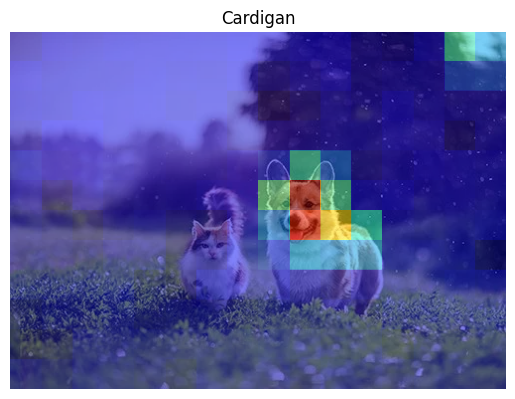

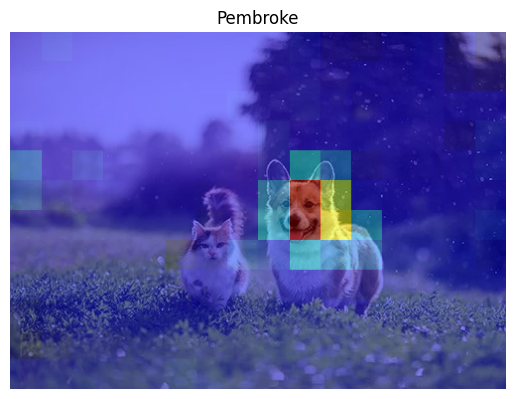

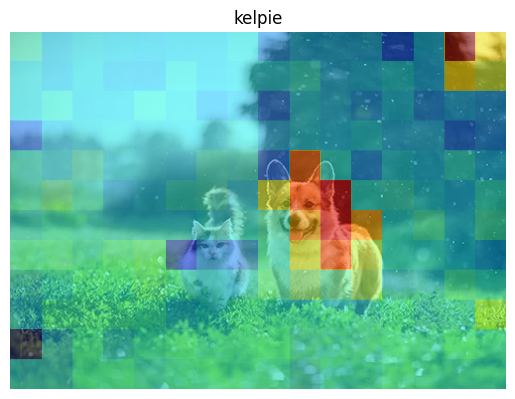

In [73]:
for index in indices:
    plt.imshow(im)
    plt.imshow(R[index, 0], cmap='jet', alpha=0.5)
    plt.title(class_names[index])
    plt.axis('off')
    plt.show()

The activations seem to point to the correct regions in this image.

Let us now see if the activation map for cat-related classes show anything at all! In this dataset, indices 281 to 287 correspond to different types of cats.

tabby Likelihood: 0.14% (0.3382)


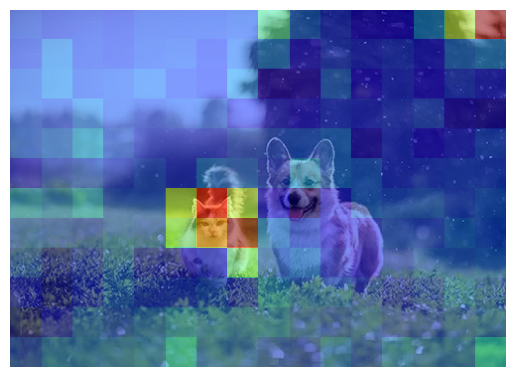

tiger cat Likelihood: 0.16% (0.4558)


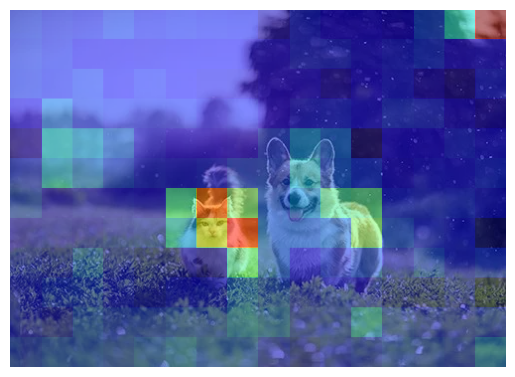

Persian cat Likelihood: 0.12% (0.1640)


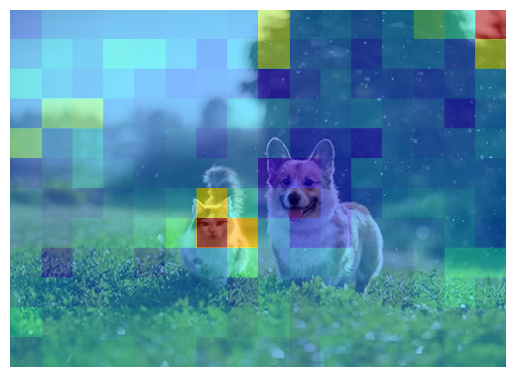

Siamese cat Likelihood: 0.14% (0.3171)


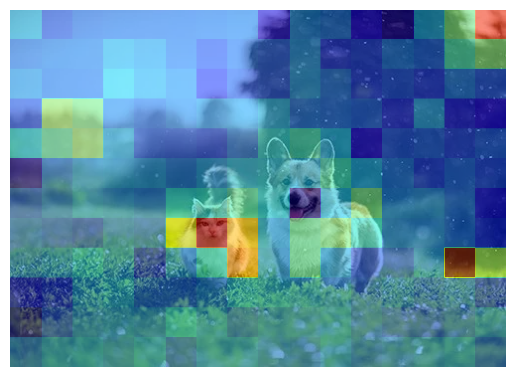

Egyptian cat Likelihood: 0.18% (0.6079)


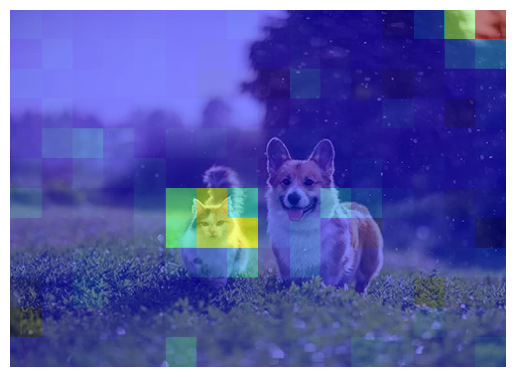

cougar Likelihood: 0.11% (0.1387)


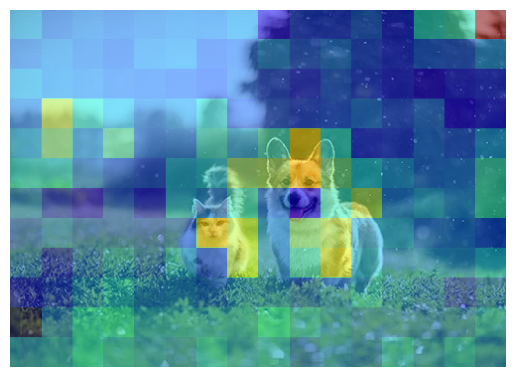

lynx Likelihood: 0.12% (0.1958)


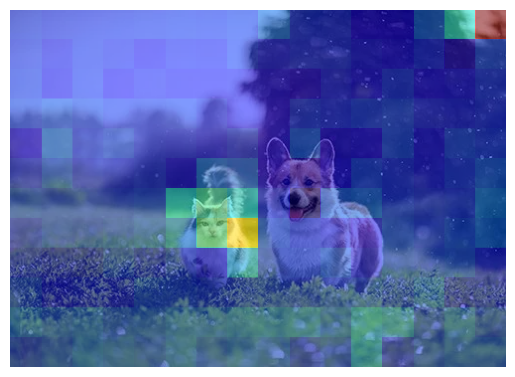

In [74]:
for index in range(281, 288):
    print(class_names[index], f'Likelihood: {proba[index].item()*100:.2f}%', f'({logits[index].item():.4f})')
    plt.imshow(im)
    plt.imshow(R[index, 0], cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

Interestingly, the cat has peaked the attention of the model and the activation maps clearly point it out. However, its logit score hasn't simply been high enough to become the dominant class after softmax is applied.

### Masking

The final interpreting method we are going to examine is masking. The idea here is that if we mask out a part of the image and the likelihood of the target class drastically changes, that part must have been crucial in making that prediction. This approach is also known as the occlusion test.

![Masking](https://miro.medium.com/v2/resize:fit:720/format:webp/1*vmbtXs1hcKMoGNPNGthtTQ.png)

Let's focus on the most likely class, `263`. We will make $32 \times 32$ patches on the image without any overlap.

In [75]:
patch = 32

To do so, we can use the `ImageDraw` API in `PIL`. We can write a simple loop to black out all possible patches.

In [76]:
width, height = im.size 

In [77]:
class_id = 263

In [86]:
i = int(np.ceil((width+1)/patch))
j = int(np.ceil((height+1)/patch))

masked_probs = np.zeros(shape=(i, j))
print(masked_probs.shape)

(16, 12)


In [88]:
# Your code goes here.

activation = torch.nn.Softmax(dim=-1)

for w in range(0, width+1, patch):
    for h in range(0, height+1, patch):
        
        masked_img = im.copy()
        draw = ImageDraw.Draw(masked_img)
        draw.rectangle(
            (w, h, w+patch, h+patch),
            fill='black',
            outline='black')
        
        sample = preprocess(masked_img)
        batch = sample.unsqueeze(0)
        logits = resnet(batch).detach()
        prob = activation(logits)
        masked_probs[w//patch, h//patch] = prob[0, class_id]

To use the same interpolation function, we need to transform this into a PyTorch tensor:

In [92]:
tensor = torch.from_numpy(masked_probs.T)
tensor = tensor.view(1, 1, 12, 16)
tensor.shape

torch.Size([1, 1, 12, 16])

Now we can use `F.interpolate`:

In [93]:
tensor = F.interpolate(tensor, (height, width))  # Your code goes here.

We can visualize the results in a similar manner. But remember that lower logits indicate that that region was important.

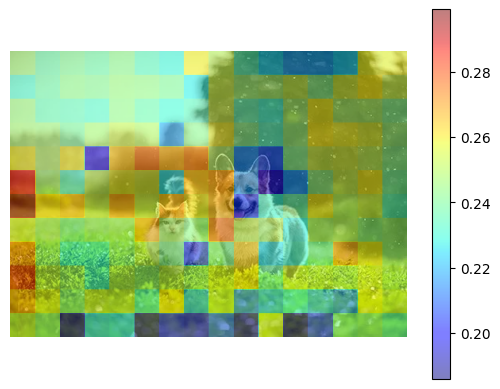

In [94]:
plt.imshow(im)
plt.imshow(tensor.squeeze() * 100, cmap='jet', alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

One weird thing to point out here is that blacking out the edges of the image, especially at the bottom, seems to drastically affect the predictions. Can you guess why?

# More Resources

There are more novel and robust approaches for interpreting ConvNets. If you are interested, you should check out [LIME](https://towardsdatascience.com/understanding-model-predictions-with-lime-a582fdff3a3b), which laid the ground for a lot of modern approaches, and [Captum](https://captum.ai/), a PyTorch library that automates a lot of these approaches and will surely come in handy.